In [1]:
import numpy as np
import scipy.linalg as linalg

import matplotlib.pyplot as plt

from io import StringIO

In [2]:
with open("concrete.mat") as f:
    data = f.read().strip().split("\n\n")
    
XTrain, XTest, yTrain, yTest = [np.loadtxt(StringIO(piece)) for piece in data]

In [3]:
def RBFKernel(X1, X2, sigma, h):
    diff = X1[:, None, :] - X2[None, :, :]
    squared_distance = np.sum(diff ** 2, axis=-1)
    K = sigma * np.exp(-squared_distance / (2 * h**2))
    return K

In [4]:
def GPRegression(XTrain, yTrain, XTest, gamma, sigma, h):
    n = len(XTrain)
    K = RBFKernel(XTrain, XTrain, sigma, h)
    K_star = RBFKernel(XTrain, XTest, sigma, h)
    K_star_star = RBFKernel(XTest, XTest, sigma, h)
    
    # Apparently, computing (K + gamma*I) ** -1 y is more numerically
    # stable through Cholesky decomposition, so that's what
    # I do here.
    L = linalg.cholesky(K + gamma * np.eye(n), lower=True)
    alpha = linalg.cho_solve((L, True), yTrain)
    mu = K_star.T @ alpha
    
    v = linalg.solve_triangular(L, K_star, lower=True)
    cov = K_star_star - v.T @ v
    
    return (mu, cov)
    

In [5]:
def LogMarginalLikelihood(XTrain, yTrain, gamma, sigma, h):
    n = len(XTrain)
    K = RBFKernel(XTrain, XTrain, sigma, h)
    covariance = K + gamma * np.eye(n)
    L = linalg.cholesky(covariance, lower=True)
    v = linalg.solve_triangular(L, yTrain, lower=True)
    
    # The exponent of the normal distribution
    answer = -np.dot(v, v) / 2
    
    # -1/2 log of (2pi)^n
    answer -= np.log(2 * np.pi) * n / 2
    
    # -1/2 log determinant of covariance matrix
    # Explanation:  det(L) = det(cov)^0.5.  L is
    # a triangular matrix, so its determinant is
    # the product of the elements on its diagonal.
    for i in range(n):
        answer -= np.log(L[i][i])
        
    return answer

In [6]:
def HyperParameters(XTrain, yTrain, hs, sigmas):
    best = None
    highest_likelihood = float('-inf')
    gamma = 0.01 * np.std(yTrain)
    
    
    sigma, h = max([(sigma_, h_) for h_ in hs for sigma_ in sigmas], key=lambda x: LogMarginalLikelihood(XTrain, yTrain, gamma, *x))
    
    return (gamma, h, sigma)

In [7]:
# Compute hyperparameters
xTrain_std = np.linalg.norm(np.std(XTrain, axis=0))
hs = np.logspace(-1, 1, 10) * xTrain_std
sigmas = np.logspace(-1, 1, 10) * np.std(yTrain)

gamma, h, sigma = HyperParameters(XTrain, yTrain, hs, sigmas)
print(gamma, h, sigma)

0.16646411925609453 19.689893179908157 166.46411925609453


In [8]:
# Get the guesses (expected value) for yTest, using our gaussian process regression and hyperparameters
guess, cov = GPRegression(XTrain, yTrain, XTest, gamma, sigma, h)

(0.0, 90.0)

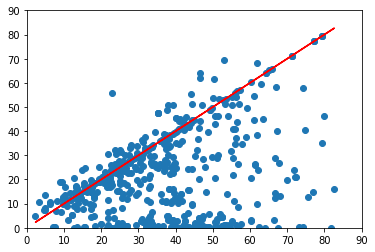

In [9]:
plt.scatter(yTest, guess)
plt.plot(yTest, yTest, c='red')
plt.ylim(0, 90)
plt.xlim(0, 90)

The above picture shows the true $y$ on the x-axis with the guessed $y$ on the y-axis.  This predictor is fairly bad.  I suspect this is because the hyperparameters are chosen poorly, since varying those gives much better results.